# Fidelity Prediction of QuCT on Quantum Simulator

**Author:** Congliang Lang & Siwei Tan  

**Date:** 7/4/2024

Based on paper "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features][1]" (MICRO 2023)

[1]: https://dl.acm.org/doi/10.1145/3613424.3614274

JanusQ enables an accurate fidelity prediction by considering the gate-dependent error (e.g. crosstalk and pulse distortion). Specifially, JanusQ uses a vectorization model to extract the topological and contextual information of circuits and intergate this information into the prediction. 

In this notebook, we introduce the fidelity prediction on the simulator. We also introduce the prediction on ther real world quantum device in the "[2_3_fidelity_prediction_realqc.ipynb][2]"

[2]: ./2_3_fidelity_prediction_realqc.ipynb


In [1]:
%matplotlib inline

import os
os.chdir("../..")
import logging
logging.basicConfig(level=logging.WARN)

import random
import numpy as np
import ray
ray.init(log_to_driver=False)

from janusq.objects.random_circuit import random_circuits
from janusq.objects.backend import  LinearBackend
from janusq.analysis.vectorization import RandomwalkModel
from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.baseline.fidelity_prediction.rb_prediction import RBModel
from janusq.simulator.gate_error_model import GateErrorModel
from janusq.simulator.noisy_simulator import NoisySimulator
from janusq.tools.ray_func import map

2025-02-08 10:58:23,623	INFO worker.py:1724 -- Started a local Ray instance.


## Constructing a vectorization model

JanusQ provides a simualtor that can model the gate-dependent error. To intialize this simulator, we first define a backend and construct a vectorization model.

In [2]:
# define backend
n_qubits = 3
n_steps = 1
n_walks = 20
backend = LinearBackend(n_qubits, 1)

In [3]:
circuits = random_circuits(backend, n_circuits=2000, n_gate_list=range(10, 400, 20), two_qubit_prob_list=[.1, .2, .4], reverse=True)
up_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
up_model.train(circuits = circuits, multi_process=True)

100%|██████████| 5/5 [00:31<00:00,  6.34s/it]


## Defining a simulator

The high gate-dependent errors in the simulator are represented by 1-step paths. The interaction is modeled by applying an RX operator with a random angle $[-\pi/20, \pi/20]$. In other words, the two gates of a 1-step path will be added with the RX operator if this path is injected with a noise.

In [4]:
# select paths to represents sigificant interactions
all_paths = up_model.all_paths()
high_error_paths = random.choices(all_paths, k = 20)

# inject these paths into the error model of the simulator
error_model = GateErrorModel.random_model(backend=backend, high_error_paths=high_error_paths)
error_model.vec_model = up_model

# construct the simualtor
simulator = NoisySimulator(backend=backend, gate_error_model = error_model)

We can use this simualtor to collect ground-truth fidelities.

In [5]:
ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=True, multi_process=True)

100%|██████████| 5/5 [23:24<00:00, 280.99s/it]


## Fidelity prediction

QuCT formulates the error $E$ of each gate as the dot-product between its vector $v_i$ and a weight vector $W$. The fidelity of the circuit $F_{circuit}$ is represented as the product of the gate fidelities (1 - gate error):
\begin{equation}
\begin{aligned}
    & E(v_i) = W^\top v_i, \\
    & F_{circuit} = \prod_{g_i \in G} (1- E(v_i)) \prod_{q \in Q} MF_{q}.
\end{aligned}
\end{equation}
The weight vector $W$ is trained by the stochastic gradient descent algorithm based on a fidelity dataset, consisting of the circuits and their ground-truth fidelities on the quantum devices.

In [6]:
# intialize the model and train weight vector W
fidelity_model = FidelityModel(up_model)
fidelity_model.train((circuits, ground_truth_fidelities), multi_process = True, max_epoch=1000)

1632it [00:00, 158771.23it/s]
408it [00:00, 44840.06it/s]


epoch: 100, 	 epoch loss = 1709.216552734375, 	 validation loss = 10.3757905960083
epoch: 200, 	 epoch loss = 1063.3021240234375, 	 validation loss = 6.2917866706848145
epoch: 300, 	 epoch loss = 1052.0506591796875, 	 validation loss = 6.2260212898254395
epoch: 400, 	 epoch loss = 1043.2392578125, 	 validation loss = 6.172171592712402
epoch: 500, 	 epoch loss = 1034.5338134765625, 	 validation loss = 6.1265363693237305
epoch: 600, 	 epoch loss = 1027.762939453125, 	 validation loss = 6.086199760437012
epoch: 700, 	 epoch loss = 1021.413330078125, 	 validation loss = 6.049252510070801
epoch: 800, 	 epoch loss = 1014.8604736328125, 	 validation loss = 6.0147929191589355
epoch: 900, 	 epoch loss = 1008.9727783203125, 	 validation loss = 5.981194019317627
epoch: 1000, 	 epoch loss = 1003.4835815429688, 	 validation loss = 5.9494476318359375
finish taining with 1002 epoch


{'circuit_bias': Array([23.109728], dtype=float32),
 'gate_params': Array([[ 3.9986613 , 19.522467  , 19.115623  ,  8.135864  ,  8.321172  ,
          8.136006  , 11.496858  , 12.68047   ,  8.607847  ,  0.09583007,
         32.12422   ,  0.        ,  0.        ],
        [15.04025   , 24.98508   , 20.009586  , 19.541933  ,  8.339279  ,
         30.32255   , 15.030147  , 15.441999  ,  4.027077  , 18.324087  ,
         18.996809  , 14.597583  , 14.098845  ],
        [30.319586  , 17.153019  , 26.47339   , 15.445255  , 17.155676  ,
         20.01618   , 35.224377  , 17.855547  , 17.829666  , 10.714575  ,
          7.331485  ,  0.        ,  0.        ],
        [17.112906  , 10.4782095 , 12.708727  , 13.362503  , 14.638655  ,
         17.871975  , 14.154989  , 32.16232   , 10.734539  ,  7.355265  ,
          0.        ,  0.        ,  0.        ],
        [10.496172  , 11.526893  , 17.776367  , 18.342676  , 35.22166   ,
         17.870127  , 13.347489  , 19.029736  ,  8.624612  ,  0.1249655

### Evaluate the Fidelity Prediction Model

QuCT is more accurate compared to previous method, such as the [random benchmarking][3]. We build a random benchmarking model to suggest that.

[3]: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.77.012307

In [7]:
from janusq.baseline.fidelity_prediction.rb_prediction import RBModel

rb_model = RBModel(simulator, multi_process = True)

100%|██████████| 1/1 [01:51<00:00, 111.23s/it]


In [8]:
# generate fidelity dataset
benchmarking_circuits = random_circuits(backend, n_circuits=100, n_gate_list=range(10, 110, 20), two_qubit_prob_list=[.4], reverse=True)
benchmarking_fidelities = np.array(map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], benchmarking_circuits, show_progress=True, multi_process=True))

rb_fidelities = np.array(map(lambda circuit: rb_model.predict_circuit_fidelity(circuit), benchmarking_circuits))
janusct_fidelities = np.array(map(lambda circuit: fidelity_model.predict_circuit_fidelity(circuit), benchmarking_circuits))

100%|██████████| 5/5 [00:23<00:00,  4.76s/it]


0.854541378183484 0.1608446889837002
0.6768170649503492 0.3294526666294393


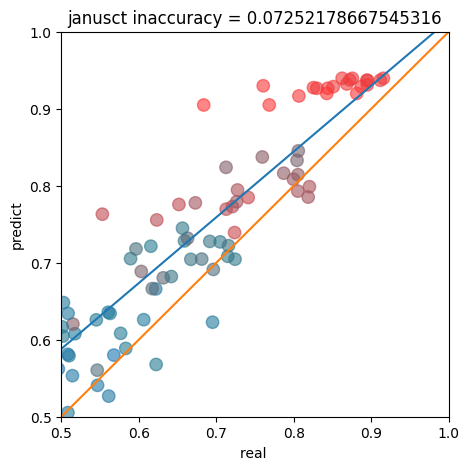

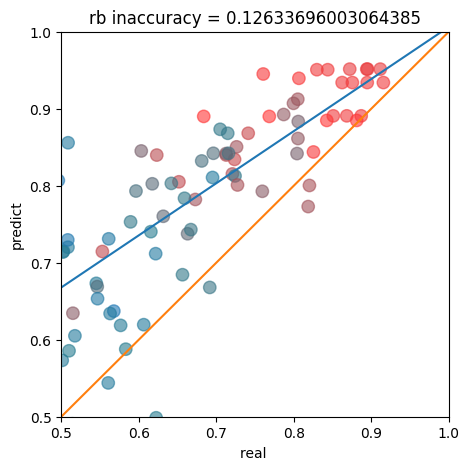

In [9]:
from janusq.tools.plot import plot_scatter

durations = np.array([cir.duration for cir in benchmarking_circuits])

fig_quct, axes_quct = plot_scatter(benchmarking_fidelities, janusct_fidelities, durations, title = f"janusct inaccuracy = {np.abs(benchmarking_fidelities - janusct_fidelities).mean()}")
fig_rb, axes_rb = plot_scatter(benchmarking_fidelities, rb_fidelities, durations, title = f"rb inaccuracy = {np.abs(benchmarking_fidelities - rb_fidelities).mean()}")
